# DOA OFDM Radar

In [1]:
import numpy as np
from numpy import linalg as lin
import scipy.signal as signal
from scipy import optimize,constants
import matplotlib.pyplot as plt

import ofdmradar
from ofdmradar import Constellation, OFDMRadar, doa

%matplotlib inline

plt.rc("figure", figsize=(15, 5))

In [2]:
f_c = 2.45e9
lmb = constants.c/f_c
f_s = 1e6
ppm = 0
receivers = 4
delta_x = lmb/2
SNR = 20

carriers = 1024
cyclic_prefix = 128

modscheme = Constellation("BPSK")

In [3]:
recv = doa.SingleToneReceiverArray(f_c, ppm, f_s, receivers, delta_x, SNR, calibrated=True)

In [4]:
class DoaOFDMRadar(OFDMRadar):
    def __init__(self, N: int, N_guard: int, N_border_margin: int, M: int, const: Constellation):
        super(DoaOFDMRadar, self).__init__(N, N_guard, N_border_margin, M, const)
    
    def periodogram(self, F_tx, frame):
        return np.array([super(DoaOFDMRadar, self).periodogram(F_tx, frame[i]) for i in range(frame.shape[0])])

In [5]:
ofdm = DoaOFDMRadar(N=1024, N_guard=128, N_border_margin=64, M=128, const=modscheme)

In [6]:
F_tx, ofdm_signal = ofdm.generate_random_frame(0)

In [7]:
targets = [
    (-np.pi/10, 10, 0.2),
    (np.pi/5, 30, 0.4),
    (0, 5, 0.3)
]

In [8]:
channels = np.zeros((cyclic_prefix*2-1, receivers), dtype=complex)

for angle, delay, mag in targets:
    channels[cyclic_prefix+delay] += recv.get_phasors(angle) * mag

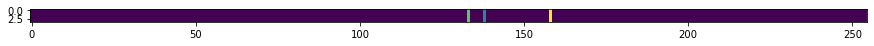

In [9]:
plt.imshow(np.abs(channels.T))

In [10]:
sigma_n = np.sqrt(1/(2 * 10 ** (SNR/10)))
rx_ = np.array([
    signal.convolve(ofdm_signal, channels[:,i], mode="same") for i in range(receivers)
])
n = (np.random.randn(*rx_.shape) + 1j* np.random.randn(*rx_.shape)) * sigma_n
rx = rx_ + n

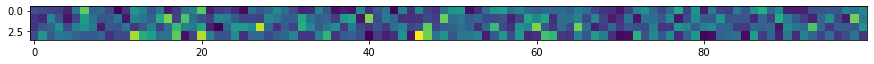

In [11]:
plt.imshow(np.abs(rx[:,:100]))

In [12]:
# estimate = ofdm.periodogram(F_tx, rx[0])

In [13]:
# plt.figure(figsize=(15, 10))
# plt.imshow(np.abs(estimate)[::-1,:], interpolation="none", aspect=1/2, extent=[-64, 63, 0, 1023])
# plt.ylim((0, 60))

In [14]:
peri = ofdm.periodogram(F_tx, rx)

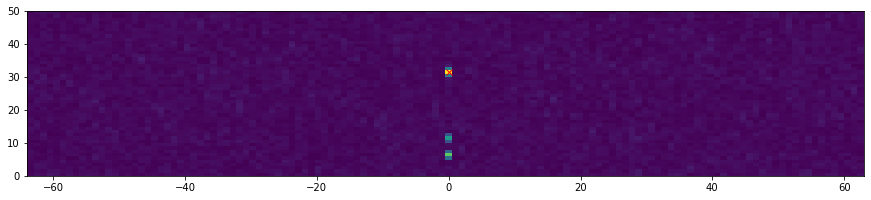

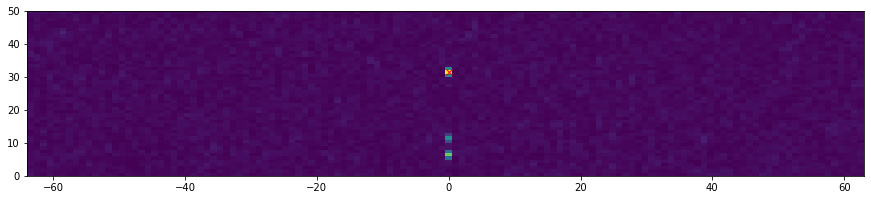

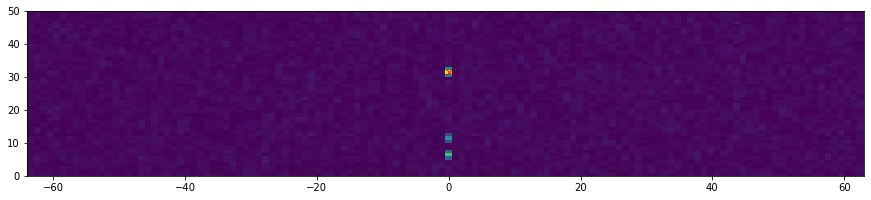

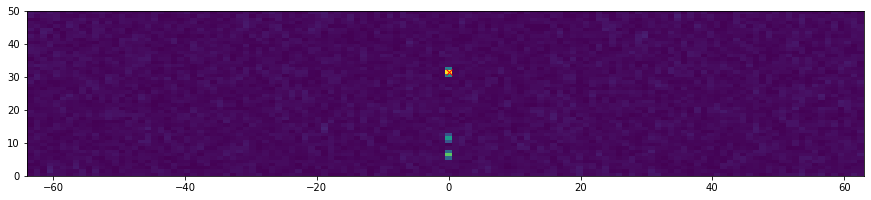

In [15]:
for estimate in peri:
    # plt.imshow(np.abs(estimate));
    plt.imshow(np.abs(estimate)[::-1,:], interpolation="none", aspect=1/2, extent=[-64, 63, 0, 1023])
    plt.plot(0, 31.5, "rx")
    plt.ylim((0, 50))
    plt.show()

In [16]:
rx = peri[:,30:31,64]

In [17]:
angle_estimates = doa.esprit(rx, 1)

In [18]:
angle_estimates - np.pi/5

array([0.00136277])

<StemContainer object of 3 artists>

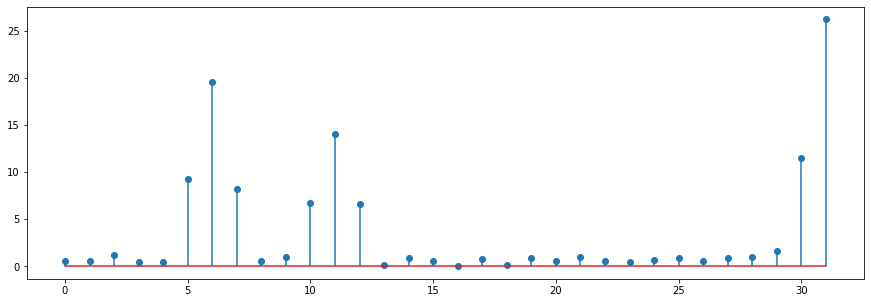

In [23]:
plt.stem(np.abs(peri[0,0:32,64]))

In [26]:
def get_angle(s, p):
    return doa.esprit(s[:,p:p+1,64], 1)

In [29]:
get_angle(peri, 11)

array([-0.31690183])

In [32]:
for angle, distance, mag in targets:
    est = get_angle(peri, distance+1)[0]
    print(f"Target distance: {distance}, true angle: {angle/np.pi*180:.2f}, estimate: {est/np.pi*180:.2f}, error: {(est-angle)/np.pi*180:.2e}")

Target distance: 10, true angle: -18.00, estimate: -18.16, error: -1.57e-01
Target distance: 30, true angle: 36.00, estimate: 35.95, error: -4.82e-02
Target distance: 5, true angle: 0.00, estimate: 0.13, error: 1.29e-01
